In [1]:
from src.houses import *
from src.agents import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots

[(     0,  135398.5575558 ,  3, 22, False, 0., 0., 0., 0.731775  )
 (     1,  132231.22753526,  3,  3, False, 0., 0., 0., 0.6046082 )
 (     2,  102147.6062945 ,  2, 63, False, 0., 0., 0., 0.77381486) ...
 (999997,  111798.36934935,  2,  1, False, 0., 0., 0., 0.7049136 )
 (999998,   59141.75938107,  1, 97, False, 0., 0., 0., 0.7896573 )
 (999999, 2958853.98647151, 10,  1, False, 0., 0., 0., 0.7086384 )]


In [3]:
n = 1_000_000
agents = generate_agents(n)
size = sys.getsizeof(agents)
print(f"The agents array takes up {size} bytes of memory, which is {size/(1024**3):.6f} GB of memory")

The agents array takes up 43000112 bytes of memory, which is 0.040047 GB of memory


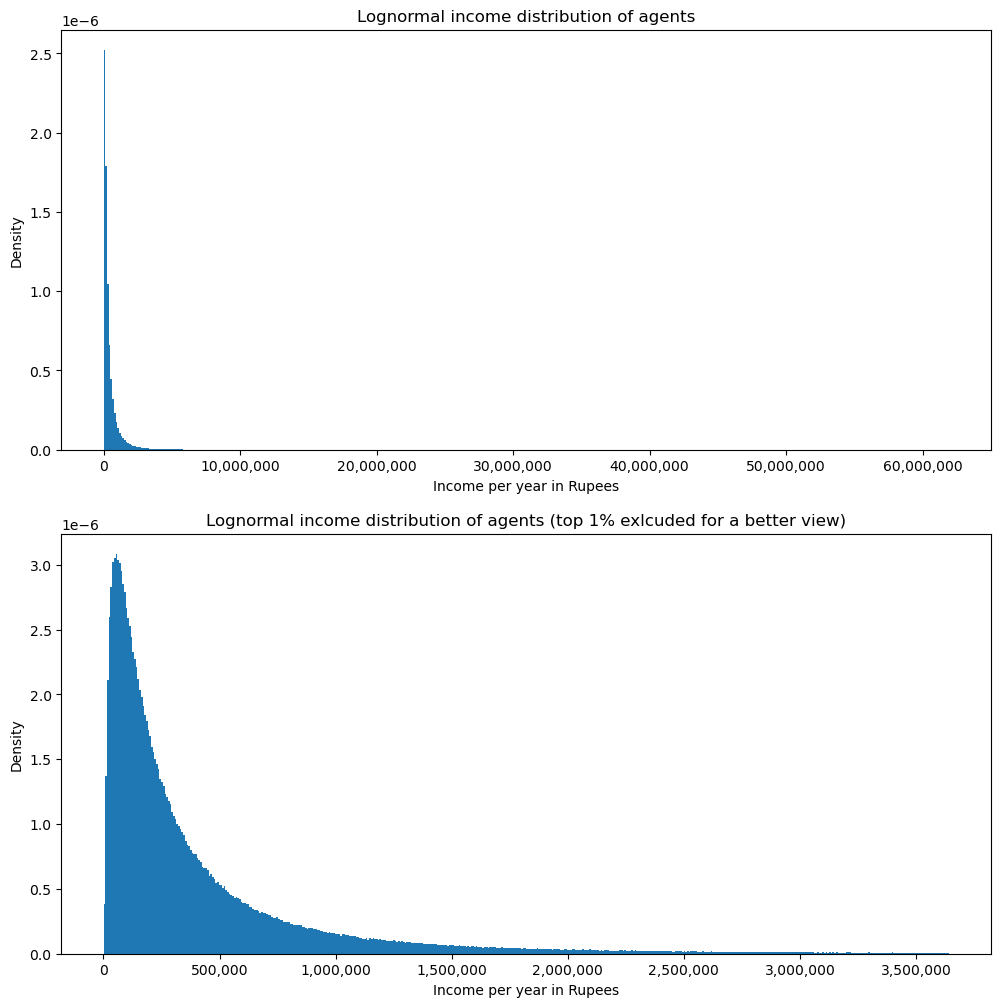

In [5]:
# plot the lognormal agents income distribution
incomes = agents["income"]

# Cut off at, say, the 99.99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Lognormal income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Lognormal income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()